# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = 'JanCarlo' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
676,55,female,39.58570,3,no,13734.380990
217,27,male,22.40700,0,no,2732.109600
864,51,male,24.63800,0,no,9660.715900
751,21,male,28.10575,0,no,2096.994075
1106,49,female,29.02725,0,no,9886.974625


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
#Multiple ways to get the number of rows: count, len(dataframe.index), dataframe.shape[0]
num_rows = dataframe['age'].count() 
print(num_rows)

num_rows = dataframe.age.count() 
print(num_rows)

df_index = dataframe.index
print(df_index)

num_rows = len(dataframe.index)
print(num_rows)

num_rows = dataframe.shape[0]
print(num_rows)




1271
1271
Int64Index([ 676,  217,  864,  751, 1106,  397, 1267, 1237,  477,  856,
            ...
             261,   19,  847,    5,  762, 1071,  981,  685,  973, 1115],
           dtype='int64', length=1271)
1271
1271


**Q: How many columns doe the dataset have**

In [10]:
#Multiple ways to get the number of columns: len(dataframe.columns), len(list(dataframe)) and dataframe.shape[1]
df_columns = dataframe.columns
print(df_columns)

num_cols = len(dataframe.columns)
print(num_cols)

df_list = list(dataframe)
print(df_list)

num_cols = len(list(dataframe))
print(num_cols)


#Shape returns a tuple as rows, columns (0,1)
df_shape = dataframe.shape
print(df_shape)

num_cols = dataframe.shape[1]
print(num_cols)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')
6
['age', 'sex', 'bmi', 'children', 'smoker', 'charges']
6
(1271, 6)
6


**Q: What are the column titles of the input variables?**

In [11]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']
print(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [12]:
#List down all columns with its corresponding data type
df_dtypes = dataframe.dtypes
print(df_dtypes)

#select all columns with a data type exclusing numeric types such as int64 and float64
categorical_cols = list(dataframe.select_dtypes(exclude=['number']))
print(categorical_cols)

#the provlem with the above code is that it's possible to select a dtype of DataTime, TimeStamp, etc
categorical_cols = list(dataframe.select_dtypes(include=[object]))
print(categorical_cols)


age           int64
sex          object
bmi         float64
children      int64
smoker       object
charges     float64
dtype: object
['sex', 'smoker']
['sex', 'smoker']


**Q: What are the column titles of output/target variable(s)?**

In [13]:
#The target variables in this dataset is the price of yearly medical bills
output_cols = ['charges']
print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [14]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [15]:
#Get the min, max and average values of the `charge` column
df_charge_min = dataframe.charges.min()
print("Min value of charges => {} ".format(df_charge_min))

df_charge_max = dataframe.charges.max()
print("Max value of charges => {} ".format(df_charge_max))

df_charge_mean = dataframe.charges.mean()
print("Average/Mean value of charges => {} ".format(df_charge_mean))


Min value of charges => 1234.06129 
Max value of charges => 70147.470811 
Average/Mean value of charges => 14584.02911214469 


In [16]:
#Suppress warnings for using distplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

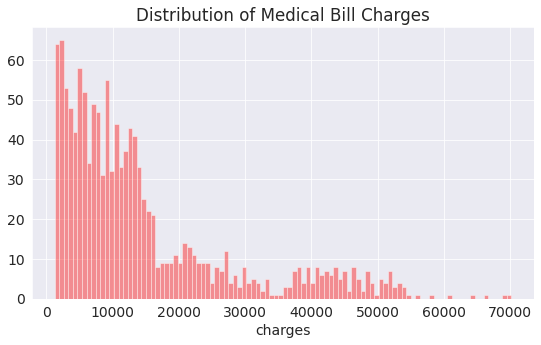

In [17]:
#Distribution of values in a graph
plt.title("Distribution of Medical Bill Charges")
sns.distplot((dataframe.charges), kde=False, color='red', bins=100)


Text(0, 0.5, 'Density')

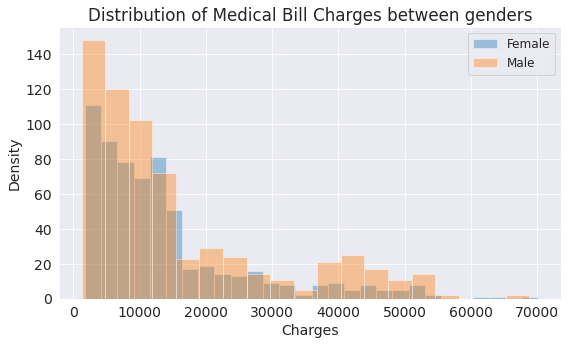

In [18]:
#Distribution of values in a graph between Genders

df = dataframe[dataframe.sex == 'female']
sns.distplot(df.charges,  kde=False, label='Female')

df = dataframe[dataframe.sex == 'male']
sns.distplot(df.charges,  kde=False, label='Male')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title("Distribution of Medical Bill Charges between genders")
plt.xlabel('Charges')
plt.ylabel('Density')



In [ ]:
#Distribution of values in a graph (using matplotlib pyplot)
plt.title("Distribution of Medical Bill Charges")
plt.hist(dataframe.charges,bins=int(180/5))
plt.xlabel("Charges", fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [19]:
!pip install jovian --upgrade -q

In [20]:
import jovian

In [21]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/jcawesome/02-insurance-linear-regression


'https://jovian.ai/jcawesome/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [22]:
#Verify if list of columns are correct
print(input_cols)
print(categorical_cols)
print(output_cols)

['age', 'sex', 'bmi', 'children', 'smoker']
['sex', 'smoker']
['charges']


In [23]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [24]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.    ,  0.    , 39.5857,  3.    ,  0.    ],
        [27.    ,  1.    , 22.407 ,  0.    ,  0.    ],
        [51.    ,  1.    , 24.638 ,  0.    ,  0.    ],
        ...,
        [53.    ,  1.    , 25.6177,  2.    ,  0.    ],
        [19.    ,  0.    , 39.285 ,  0.    ,  0.    ],
        [55.    ,  1.    , 31.6899,  1.    ,  0.    ]]), array([[13734.38099],
        [ 2732.1096 ],
        [ 9660.7159 ],
        ...,
        [12368.81459],
        [ 1935.2718 ],
        [11888.23493]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [25]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [26]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [27]:
#Inputs
print(inputs)
#Targets
print(targets)

tensor([[55.0000,  0.0000, 39.5857,  3.0000,  0.0000],
        [27.0000,  1.0000, 22.4070,  0.0000,  0.0000],
        [51.0000,  1.0000, 24.6380,  0.0000,  0.0000],
        ...,
        [53.0000,  1.0000, 25.6177,  2.0000,  0.0000],
        [19.0000,  0.0000, 39.2850,  0.0000,  0.0000],
        [55.0000,  1.0000, 31.6899,  1.0000,  0.0000]])
tensor([[13734.3809],
        [ 2732.1096],
        [ 9660.7158],
        ...,
        [12368.8145],
        [ 1935.2719],
        [11888.2354]])


Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [28]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [29]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
print(val_size)
print(train_size)


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

190
1081


Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [34]:
batch_size = 32

In [35]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [36]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[49.0000,  0.0000, 22.4846,  2.0000,  0.0000],
        [54.0000,  1.0000, 28.3240,  1.0000,  0.0000],
        [24.0000,  0.0000, 38.3053,  0.0000,  0.0000],
        [53.0000,  1.0000, 40.2259,  0.0000,  0.0000],
        [60.0000,  0.0000, 36.9182,  0.0000,  0.0000],
        [58.0000,  0.0000, 31.9760,  0.0000,  0.0000],
        [40.0000,  1.0000, 24.2209,  2.0000,  0.0000],
        [19.0000,  0.0000, 23.9590,  0.0000,  0.0000],
        [63.0000,  0.0000, 26.9078,  0.0000,  1.0000],
        [26.0000,  1.0000, 31.9130,  2.0000,  1.0000],
        [50.0000,  0.0000, 43.4026,  0.0000,  0.0000],
        [21.0000,  1.0000, 30.1670,  0.0000,  0.0000],
        [33.0000,  0.0000, 17.9450,  1.0000,  0.0000],
        [33.0000,  0.0000, 38.6254,  1.0000,  0.0000],
        [34.0000,  1.0000, 33.1837,  0.0000,  0.0000],
        [52.0000,  1.0000, 31.7917,  3.0000,  0.0000],
        [52.0000,  0.0000, 24.5410,  2.0000,  1.0000],
        [47.0000,  1.0000, 27.3685,  3.0000,  1.0000],
  

Let's save our work by committing to Jovian.

In [33]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/jcawesome/02-insurance-linear-regression


'https://jovian.ai/jcawesome/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [37]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [38]:
model=nn.Linear(input_size, output_size)

In [39]:
print(model.weight.shape)
model.weight

torch.Size([1, 5])


Parameter containing:
tensor([[-0.2607, -0.3092, -0.4144,  0.0039,  0.2062]], requires_grad=True)

In [40]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                      # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)        
        # Calcuate loss
        loss = F.smooth_l1_loss(out,targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out,targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [41]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [42]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1609,  0.0597, -0.0537, -0.2105,  0.4216]], requires_grad=True),
 Parameter containing:
 tensor([0.0646], requires_grad=True)]

One final commit before we train the model.

In [43]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/jcawesome/02-insurance-linear-regression


'https://jovian.ai/jcawesome/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [44]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [45]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13790.7685546875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [46]:
model = InsuranceModel()

In [47]:
epochs = 1000
lr = 1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 6667.5903
Epoch [200], val_loss: 6684.3638
Epoch [300], val_loss: 6530.0259
Epoch [400], val_loss: 6378.5757
Epoch [500], val_loss: 6116.7515
Epoch [600], val_loss: 6224.5679
Epoch [700], val_loss: 5925.8003
Epoch [800], val_loss: 5739.5073
Epoch [900], val_loss: 5622.0708
Epoch [1000], val_loss: 5486.3794


In [48]:
epochs = 2000
lr = 1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 5391.8027
Epoch [200], val_loss: 5419.4189
Epoch [300], val_loss: 5134.1313
Epoch [400], val_loss: 5086.2314
Epoch [500], val_loss: 5152.5762
Epoch [600], val_loss: 4733.4404
Epoch [700], val_loss: 4623.3779
Epoch [800], val_loss: 4523.2241
Epoch [900], val_loss: 4396.0073
Epoch [1000], val_loss: 4455.1514
Epoch [1100], val_loss: 4257.2212
Epoch [1200], val_loss: 4177.1479
Epoch [1300], val_loss: 4260.6021
Epoch [1400], val_loss: 4187.7925
Epoch [1500], val_loss: 4079.8027
Epoch [1600], val_loss: 4031.7520
Epoch [1700], val_loss: 4146.4028
Epoch [1800], val_loss: 4851.7593
Epoch [1900], val_loss: 4071.3330
Epoch [2000], val_loss: 3988.8047


In [50]:
epochs = 1000
lr = 1e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 3985.8711
Epoch [200], val_loss: 3987.2004
Epoch [300], val_loss: 3987.3291
Epoch [400], val_loss: 3985.7158
Epoch [500], val_loss: 3988.0212
Epoch [600], val_loss: 3987.5603
Epoch [700], val_loss: 3985.1887
Epoch [800], val_loss: 3985.9070
Epoch [900], val_loss: 3984.8220
Epoch [1000], val_loss: 3986.7842


In [51]:
epochs = 1000
lr = 1e-3
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 3986.2168
Epoch [200], val_loss: 3986.1484
Epoch [300], val_loss: 3986.1570
Epoch [400], val_loss: 3986.1008
Epoch [500], val_loss: 3986.1709
Epoch [600], val_loss: 3986.1272
Epoch [700], val_loss: 3986.0916
Epoch [800], val_loss: 3986.1067
Epoch [900], val_loss: 3986.1042
Epoch [1000], val_loss: 3986.1399


In [52]:
epochs = 1000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 3986.1218
Epoch [200], val_loss: 3986.0984
Epoch [300], val_loss: 3986.1008
Epoch [400], val_loss: 3986.1013
Epoch [500], val_loss: 3986.0977
Epoch [600], val_loss: 3986.1033
Epoch [700], val_loss: 3986.1062
Epoch [800], val_loss: 3986.0977
Epoch [900], val_loss: 3986.1035
Epoch [1000], val_loss: 3986.0793


**Q: What is the final validation loss of your model?**

In [53]:
val_loss = history5[-1]['val_loss']
val_loss

3986.079345703125

Let's log the final validation loss to Jovian and commit the notebook

In [54]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [55]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/jcawesome/02-insurance-linear-regression


'https://jovian.ai/jcawesome/02-insurance-linear-regression'

In [56]:
import math
math.sqrt(val_loss)

63.135404851027324

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [57]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [58]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([43.0000,  0.0000, 26.0784,  0.0000,  1.0000])
Target: tensor([23951.7539])
Prediction: tensor(25904.5352)


In [59]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([58.0000,  0.0000, 27.3685,  0.0000,  0.0000])
Target: tensor([13446.7861])
Prediction: tensor(12949.2773)


In [60]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([28.0000,  0.0000, 25.5256,  3.0000,  0.0000])
Target: tensor([5843.3867])
Prediction: tensor(5590.4961)


**I'm happy with these predictions** (after trying multiple combinations of the parameters

In [ ]:
jovian.commit(project=project_name, environment=None)